In [1]:
import astropy
import numpy as np
import matplotlib
import pandas as pd

from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import sem 

In [2]:
plt.rcParams['figure.figsize'] = (12, 9)

In [3]:
file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits')

In [44]:
ang_d = np.load('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_arr/ang_d_HI.npy') # HI; there are corresponding RA and DEC arrays
diff_and_sq = np.load('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_arr/diff_and_sq_HI.npy')
diff_and_sq_SS = np.load('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_arr/diff_and_sq_HI_SS.npy') 
diff_and_sq_H2 = np.load('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_arr/diff_and_sq_H2.npy') 
ang_d_H2 = np.load('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_arr/ang_d_H2.npy') 


In [40]:
# normalization factor from image space to k-space = (2 * pi) / delta RA
# denominator = delta RA = number pixels (since trying to move to pixel space)

k_min = (2 * np.pi) / np.sqrt((3901 ** 2) + (3471 ** 2))

In [45]:
# before fftshifting
k = np.radians(ang_d) * (2 * np.pi / k_min)

# after fftshifting
k = (np.sqrt((3901 ** 2) + (3471 ** 2))/2) - k

In [41]:
# before fftshifting
k2 = np.radians(ang_d_H2) * (2 * np.pi / k_min)

# after fftshifting
k2 = (np.sqrt((3901 ** 2) + (3471 ** 2))/2) - k2

Greater angular distance = lower frequencies


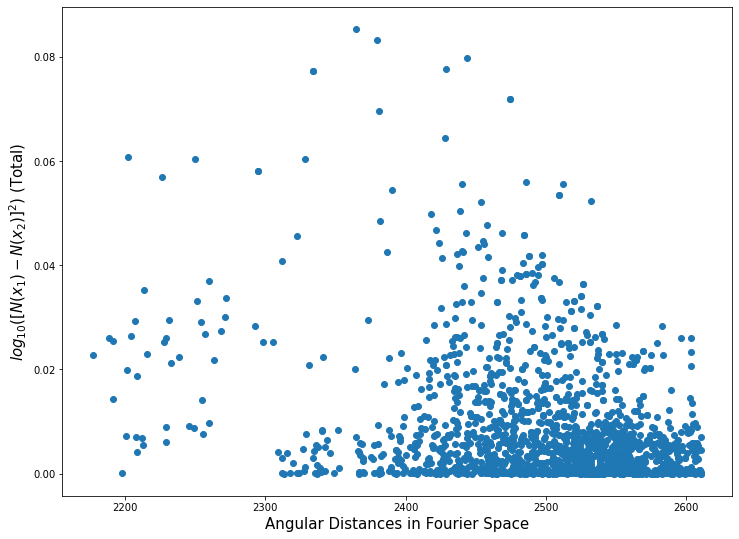

In [46]:
# larger x-values correspond to lower frequencies

plt.scatter(k, diff_and_sq)
plt.xlabel('Angular Distances in Fourier Space', fontsize = 15)
plt.ylabel('$log_{10}([N(x_1) - N(x_2)]^2)$ (Total)', fontsize = 15)
print('Greater angular distance = lower frequencies')

Greater angular distance = lower frequencies


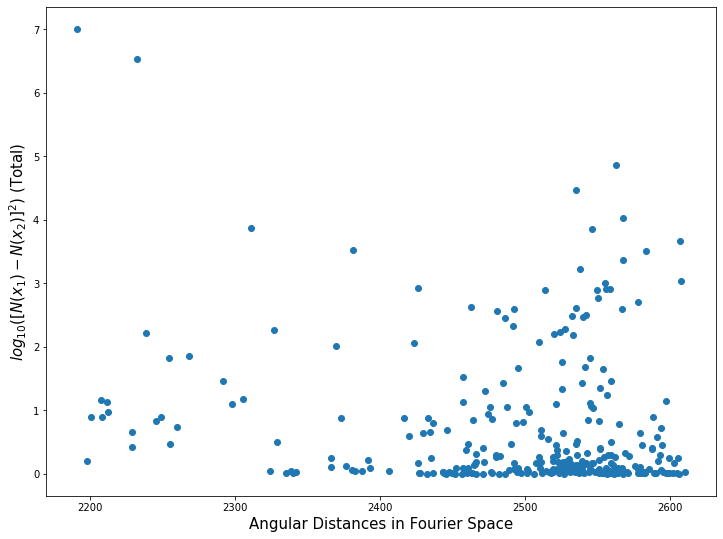

In [47]:
# larger x-values correspond to lower frequencies

plt.scatter(k, diff_and_sq_SS)
plt.xlabel('Angular Distances in Fourier Space', fontsize = 15)
plt.ylabel('$log_{10}([N(x_1) - N(x_2)]^2)$ (Total)', fontsize = 15)
print('Greater angular distance = lower frequencies')

Greater angular distance = lower frequencies


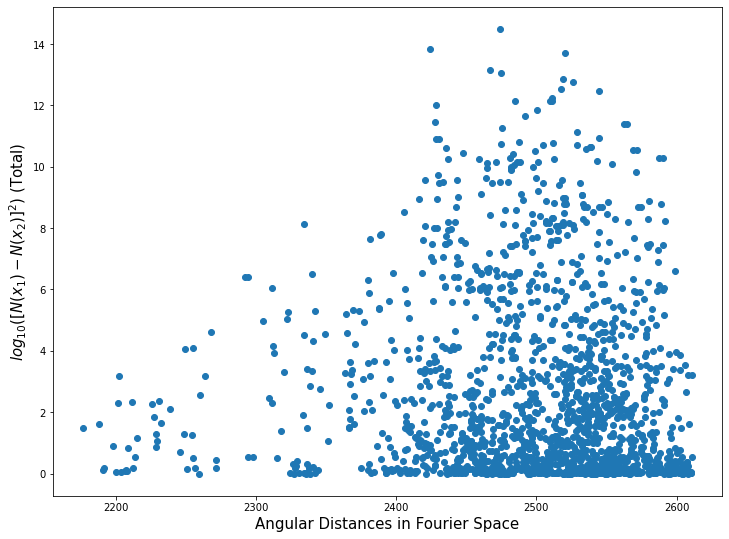

In [7]:
# larger x-values correspond to lower frequencies

plt.scatter(k2, diff_and_sq_H2)
plt.xlabel('Angular Distances in Fourier Space', fontsize = 15)
plt.ylabel('$log_{10}([N(x_1) - N(x_2)]^2)$ (Total)', fontsize = 15)
print('Greater angular distance = lower frequencies')

In [38]:
# helper function that returns an array of values to be averaged, given the number of values that should be in each bin
# bins by equal # of values in each bin

def sep_by_bin(values, k, num_bin_vals, indx):
    arr = [] # = values for bin
    count = 0 # number of values in current bin
    order = np.argsort(np.array(k))
    k.sort() # sorting k in increasing order
    values = np.array(values)[order].tolist() # sorting values in same order as k so they correspond
    
    while (count < num_bin_vals) & (indx < len(values)):
        arr.append(values[indx])
        count += 1
        indx += 1
        
    return arr, indx


In [39]:
# helper function that does the binning by intaking array of values inside the < > + the corresponding angular distances, # bins desired
# bins by equal number of values in each bin

def do_binning(diff_and_sq, k, num_bins):
    num_bin_vals = len(diff_and_sq) / float(num_bins) # = number of values that should be in each bin
    indx = 0 # indx in diff_and_sq/k that we at
    avgs = [] # holds mean values for each bin
    x_ax = [] # holds x-axis label values
    tot_err = [] # holds error bar values
    
    while (indx < len(diff_and_sq)):
        prev_indx = indx # for the x-axis label
        vals, indx = sep_by_bin(diff_and_sq, k, num_bin_vals, indx)
        avgs.append(np.mean(vals))
        
        if indx < len(diff_and_sq):
            x_ax.append(str('%.1f' % (k[prev_indx])) + ' - ' + str('%.1f' % (k[indx])))
        else:
            x_ax.append(str('%.1f' % (k[prev_indx])))
            
        tot_err.append(sem(vals)) # error based on standard error of the mean
        
    return avgs, x_ax, tot_err, int(num_bin_vals)


In [62]:
def struct_func(num_bins, SS = False, H2 = False, xtick = 0):
    # binning
    if SS:
        
        avgs, x_ax, tot_err, num_bin_vals = do_binning(diff_and_sq_SS[np.where((np.isnan(diff_and_sq_SS) == False) & (np.isposinf(diff_and_sq_SS) == False) & (np.isneginf(diff_and_sq_SS) == False))], 
                                                       k[np.where((np.isnan(diff_and_sq_SS) == False) & (np.isposinf(diff_and_sq_SS) == False) & (np.isneginf(diff_and_sq_SS) == False))], num_bins)
    elif H2:
        avgs, x_ax, tot_err, num_bin_vals = do_binning(diff_and_sq_H2, k2, num_bins)
    else:
        avgs, x_ax, tot_err, num_bin_vals = do_binning(diff_and_sq, k, num_bins)
    
    # building plot
    fig, ax = plt.subplots()
    ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)
    
    if num_bins >= 10: 
        ax.axes.get_xaxis().set_ticks([]) # don't include ticks/labels on x-axis since they become overcrowded
        
    ax.set_xlabel("Angular Distances in Fourier Space", fontsize = 15)
    ax.set_ylabel("S(\u0394x) = $\mathregular{<[N(x_1) - N(x_2)]^2>}$ ($\mathregular{cm^{-2}}$)", fontsize = 15)
    if xtick != 0:
        ax.set_xticks([xtick])

    if SS:
        plt.title('HI Small-Scale Column Densities @ $H_2$ Sightlines, ' + str(num_bin_vals) + ' Values Per Bin, ' + str(num_bins) + ' Bins', fontsize = 20)
    elif H2:
        plt.title('$H_2$ Column Densities @ $H_2$ Sightlines, ' + str(num_bin_vals) + ' Values Per Bin, ' + str(num_bins) + ' Bins', fontsize = 20)
    else:
        plt.title('HI Total Column Densities @ $H_2$ Sightlines, ' + str(num_bin_vals) + ' Values Per Bin, ' + str(num_bins) + ' Bins', fontsize = 20)
    print('Greater angular distances = lower frequencies')
    

Greater angular distances = lower frequencies


/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_84384/1984354360.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


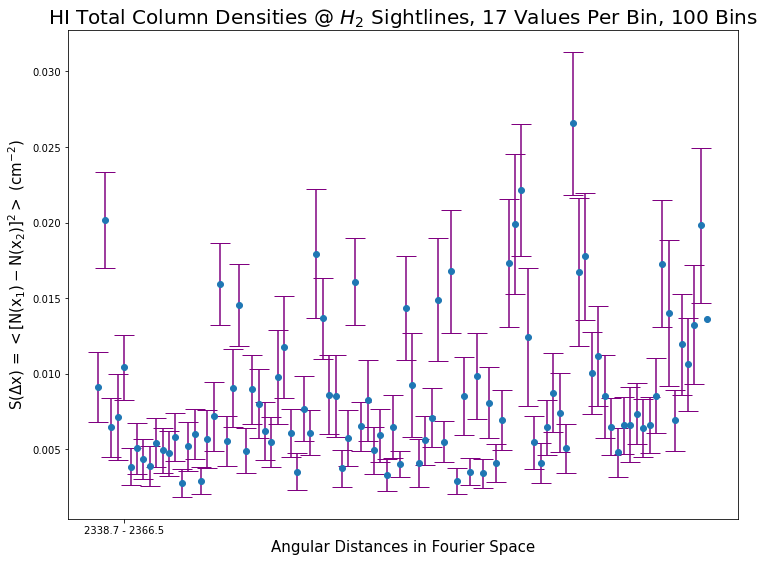

In [52]:
struct_func(100, xtick = 4)

Greater angular distances = lower frequencies


/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_84384/2291927198.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


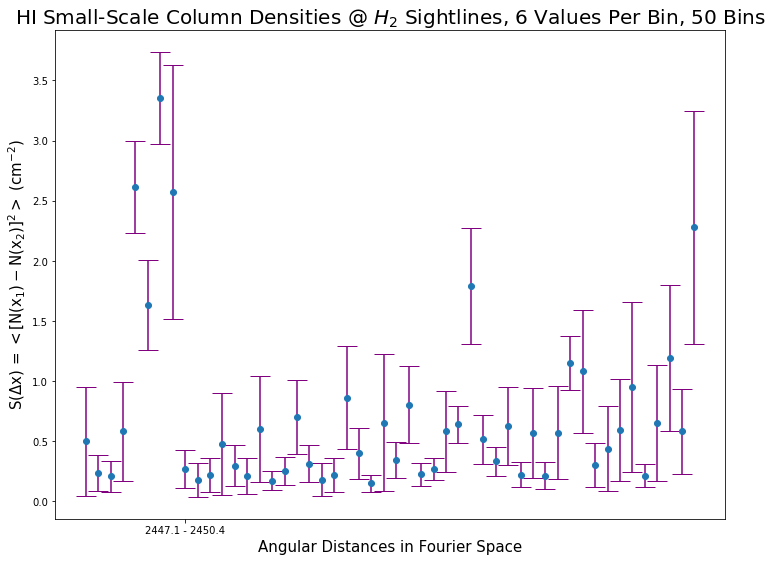

In [64]:
struct_func(50, SS = True, xtick = 8)

Greater angular distances = lower frequencies


/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_84384/1984354360.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


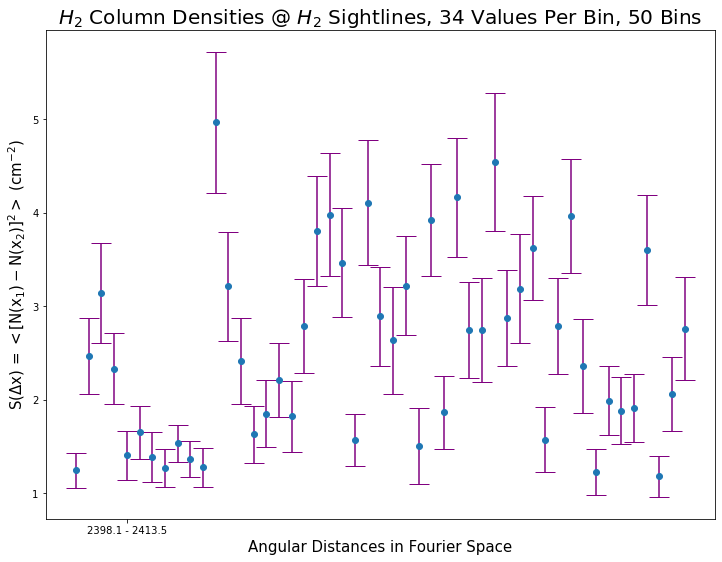

In [42]:
struct_func(50, H2 = True, xtick = 4)